In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.fft import fft, fftfreq, ifft
from scipy.optimize import minimize

from fooof import FOOOF

from neurodsp.sim import sim_powerlaw, sim_bursty_oscillation, sim_oscillation
from neurodsp.spectral import compute_spectrum

# Aperiodic/Periodic Decomposition

A way to separate aperiodic and periodic components in time. 

1. Find mask of oscillatory frequencies with fooof
2. Compute and weight FFT, within oscillatory mask, with weights.
4. Solve FFT weights to optimize for the peak removed spectrum found by SpecParam.
5. The inverse of the weighted FFT gives the aperiodic signal estimate.

This is first demonstrated in a real signal. Followed by a simulated asine wave.

## Real Data from CA1

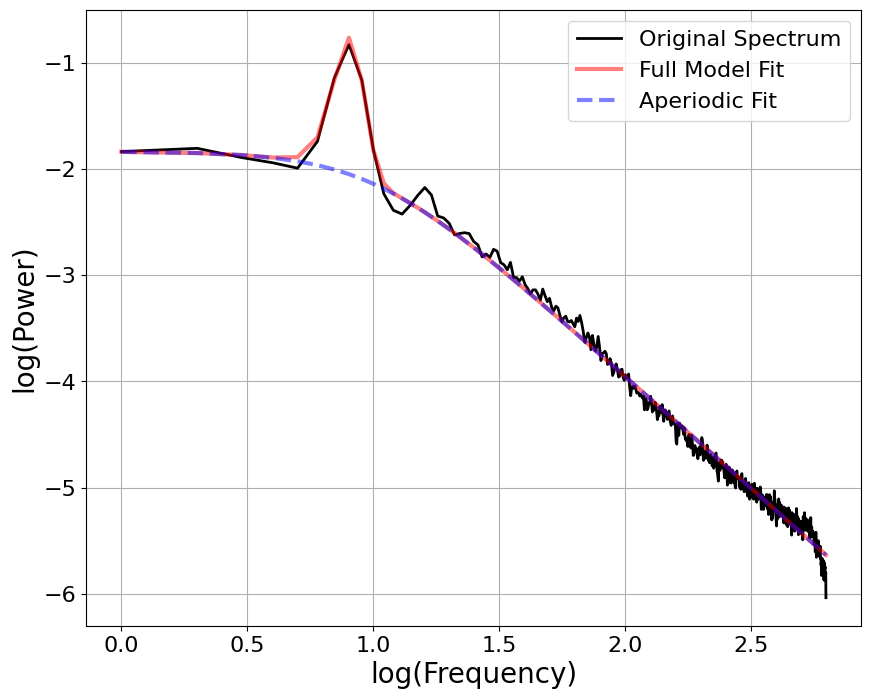

In [2]:
# Load
sig = np.load('ca1.npy')
fs = 1250

# SpecParam
freqs, powers = compute_spectrum(sig, fs)
fm = FOOOF(max_n_peaks=2, aperiodic_mode='knee',
           peak_threshold=4, verbose=False)

fm.fit(freqs, powers)
fm.plot(plt_log=True)

### Optimization Procedure

Weights for the real and imaginary part of the FFT, in the frequency range of oscillation found by SpecParam, are learned to give an aperiodic PSD close the the aperiodic SpecParam estimate. This is kind of like a SpecParam "filter".

The code in the next two cells is all that is need for the decomposition.

In [3]:
def loss(sig, fmask, powers_ap_log, psdfunc, ffreqs, fcoefs, fs, *params):
    """Define loss for decomposing aperiodic in the time domain."""
    
    # Split parameters into real and imaginary parts
    parray = np.array(params)
    sig_pred, fcoefs_pred, powers_pred_log = apply_fourier_weights(fcoefs, parray)

    # Compute loss as mean-squared error
    mse = ((powers_ap_log-powers_pred_log)**2).mean()
 
    return mse


def apply_fourier_weights(fcoefs, parray):
    """Weights fourier coeffients by optimized parray. """

    # Split weights into real and imag
    parray_real = parray[:len(parray)//2]
    parray_imag = parray[len(parray)//2:]
    
    # Transform fourier coefficeints to abs()**(1/fs)
    fcoefs_pred = fcoefs.copy()
    fcoefs_imag = fcoefs.imag.copy()
    fcoefs_sign = np.sign(fcoefs_pred.real)
    fcoefs_pred.real = np.abs(fcoefs_pred.real)**(1/fs)
    
    # Weight fourier coefficients
    fcoefs_pred[fmask].real *= parray_real
    
    # Back to original fft space
    fcoefs_pred.real = (fcoefs_pred.real**(fs)) * fcoefs_sign
    fcoefs_pred.imag = fcoefs_imag
    
    # Phase
    fcoefs_pred[fmask] *= parray_imag
    
    # Convert back to time domain
    sig_pred = ifft(fcoefs_pred).real
    powers_pred_log = psdfunc(sig_pred)
    
    return sig_pred, fcoefs_pred, powers_pred_log


def psdfunc_wrap(sig, fs):
    """Wrap spectral function."""
    f, p = compute_spectrum(sig, fs)
    return np.log10(p[1:])

In [4]:
# Forward psd function
psdfunc = lambda sig : psdfunc_wrap(sig, fs)

ffreqs = fftfreq(len(sig), 1/fs)
fcoefs = fft(sig)

# Target PSD
powers_ap_log = fm._spectrum_peak_rm

# Fourier periodic mask
inds = fm._peak_fit > .5
fpad = 1

ffreqs_abs = np.abs(ffreqs)
fmask = np.zeros(len(ffreqs), dtype=bool)

for f in fm.freqs[inds]:
    fmask[(ffreqs_abs >= f-fpad) & (ffreqs_abs <= f+fpad)] = True

# Inital fourier coefficient weights and bounds
pinit = np.append(
    np.ones(fmask.sum()),
    np.zeros(fmask.sum())
)

bounds = [(1e-24, 1.01)] * fmask.sum()
bounds.extend([[-10, 10]] * fmask.sum())


# Wrapp loss and minimize
lloss = lambda params : loss(sig, fmask, powers_ap_log, psdfunc, ffreqs, fcoefs, fs, *params)

res = minimize(lloss, pinit, method="L-BFGS-B", bounds=bounds,
               options={'disp': True, 'maxiter': 100000, 'maxfun':100000})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          964     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23879D-02    |proj g|=  2.94366D-02

At iterate    1    f=  1.53549D-02    |proj g|=  1.78540D-02

At iterate    2    f=  1.15876D-02    |proj g|=  8.41892D-03

At iterate    3    f=  9.70016D-03    |proj g|=  5.90487D-03

At iterate    4    f=  6.37361D-03    |proj g|=  3.60021D-03

At iterate    5    f=  1.77868D-03    |proj g|=  1.29693D-03

At iterate    6    f=  1.03899D-03    |proj g|=  5.89613D-04

At iterate    7    f=  6.75458D-04    |proj g|=  2.54166D-04

At iterate    8    f=  5.57000D-04    |proj g|=  1.33685D-04

At iterate    9    f=  5.09877D-04    |proj g|=  6.62276D-05

At iterate   10    f=  4.69733D-04    |proj g|=  7.80905D-05

At iterate   11    f=  3.97175D-04    |proj g|=  1.20641D-04

At iterate   12    f=  2.64113D-04    |proj g|=  2.20231D-04

At iterate   13    f=  1.0

In [5]:
# Get results
opt_weights = res.x

sig_ap_pred, fcoefs_pred, powers_pred_log = apply_fourier_weights(fcoefs, opt_weights)

### Real Data Results

The fourier optimization allows the weighted FFT cofficients to be convert back to the time domain via iFFT. This results in a signal that corresponds to the aperiodic SpecParam fit. Subtracting for aperiodic signal estimate gives the oscillatory signal estimate.

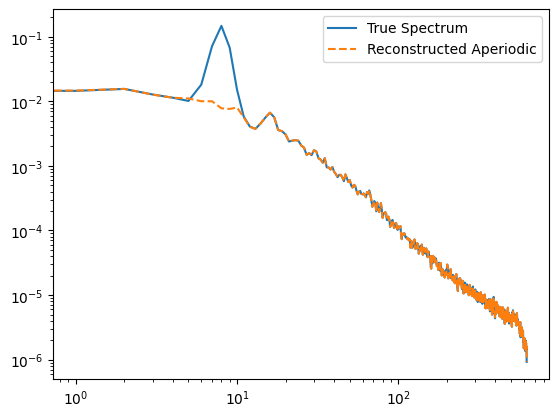

In [6]:
_freqs, _powers = compute_spectrum(sig, fs)

plt.loglog(*compute_spectrum(sig, fs), label='True Spectrum')
plt.loglog(*compute_spectrum(sig_ap_pred, fs), ls='--', label='Reconstructed Aperiodic')
plt.legend();

Text(0.5, 1.0, 'Aperiodic Estimate')

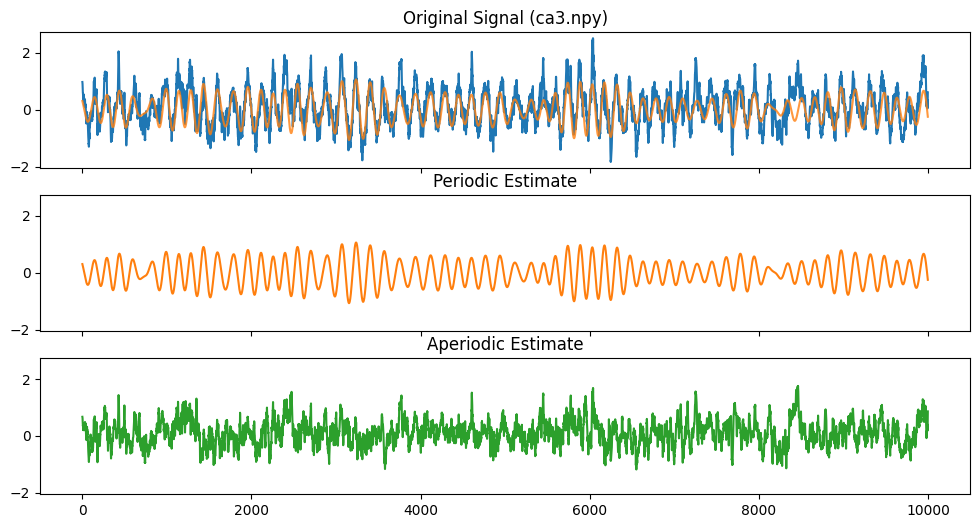

In [7]:
fig, axes = plt.subplots(nrows=3, figsize=(12, 6), sharey=True, sharex=True)

i = 10000
axes[0].plot(sig[:i])
axes[0].set_title('Original Signal (ca3.npy)')
axes[0].plot((sig-sig_ap_pred)[:i], color='C1', alpha=.8)

axes[1].plot((sig-sig_ap_pred)[:i], color='C1')
axes[1].set_title('Periodic Estimate')

axes[2].plot((sig_ap_pred)[:i], color='C2')
axes[2].set_title('Aperiodic Estimate')

## Simulated Asine

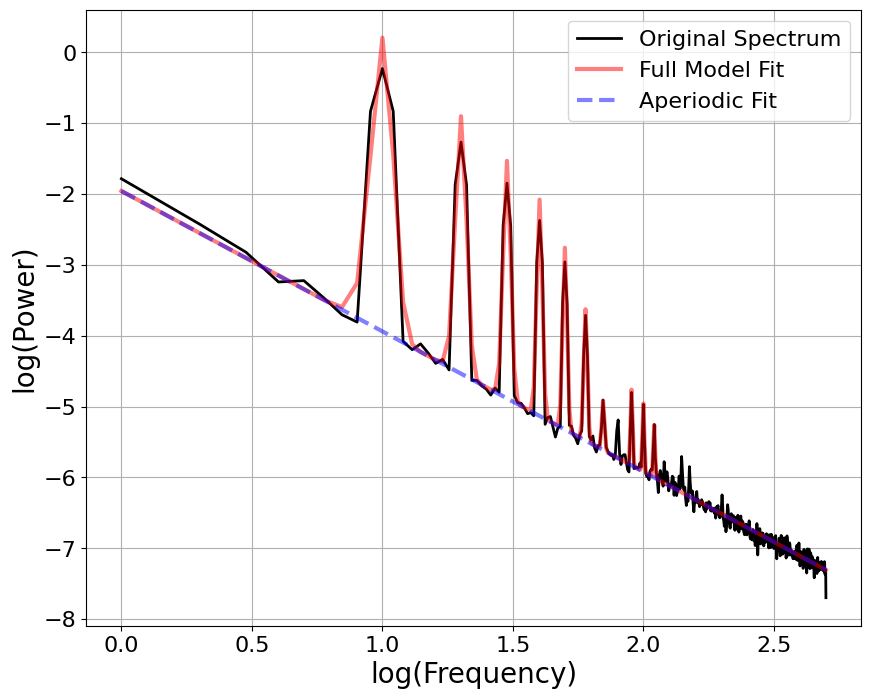

In [18]:
n_seconds = 25
fs = 1000

# Simulate
np.random.seed(0)
sig_ap = sim_powerlaw(n_seconds, fs)
sig_pe = sim_oscillation(n_seconds, fs, 10, cycle='asine', rdsym=.8)
sig = sig_ap + sig_pe

# SpecParam
freqs, powers = compute_spectrum(sig, fs)
fm = FOOOF(max_n_peaks=10, verbose=False)

fm.fit(freqs, powers)
fm.plot(plt_log=True)

In [19]:
# Forward psd function
psdfunc = lambda sig : psdfunc_wrap(sig, fs)

ffreqs = fftfreq(len(sig), 1/fs)
fcoefs = fft(sig)

# Target PSD
powers_ap_log = fm._spectrum_peak_rm

# Fourier periodic mask
inds = fm._peak_fit > .5
fpad = 1

ffreqs_abs = np.abs(ffreqs)
fmask = np.zeros(len(ffreqs), dtype=bool)

for f in fm.freqs[inds]:
    fmask[(ffreqs_abs >= f-fpad) & (ffreqs_abs <= f+fpad)] = True

# Inital fourier coefficient weights and bounds
pinit = np.append(
    np.ones(fmask.sum()),
    np.zeros(fmask.sum())
)

bounds = [(1e-24, 1.01)] * fmask.sum()
bounds.extend([[-10, 10]] * fmask.sum())


# Wrap loss and minimize
lloss = lambda params : loss(sig, fmask, powers_ap_log, psdfunc, ffreqs, fcoefs, fs, *params)

res = minimize(lloss, pinit, method="L-BFGS-B", bounds=bounds,
               options={'iprint': 20, 'maxiter': 300000, 'maxfun':300000})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3440     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34125D-01    |proj g|=  2.58995D+00

At iterate   20    f=  1.80283D-02    |proj g|=  2.80867D-02

At iterate   40    f=  1.54469D-02    |proj g|=  4.18724D-03

At iterate   60    f=  1.41796D-02    |proj g|=  2.33455D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3440     64     89     64     0     0   1.214D-03   1.415D-02
  F =   1.4154430079178614E-002

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


In [20]:
# Get results
opt_weights = res.x

sig_ap_pred, fcoefs_pred, powers_pred_log = apply_fourier_weights(fcoefs, opt_weights)

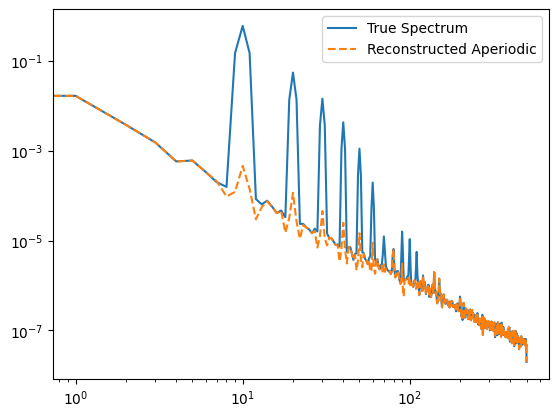

In [21]:
_freqs, _powers = compute_spectrum(sig, fs)

plt.loglog(*compute_spectrum(sig, fs), label='True Spectrum')
plt.loglog(*compute_spectrum(sig_ap_pred, fs), ls='--', label='Reconstructed Aperiodic')
plt.legend();

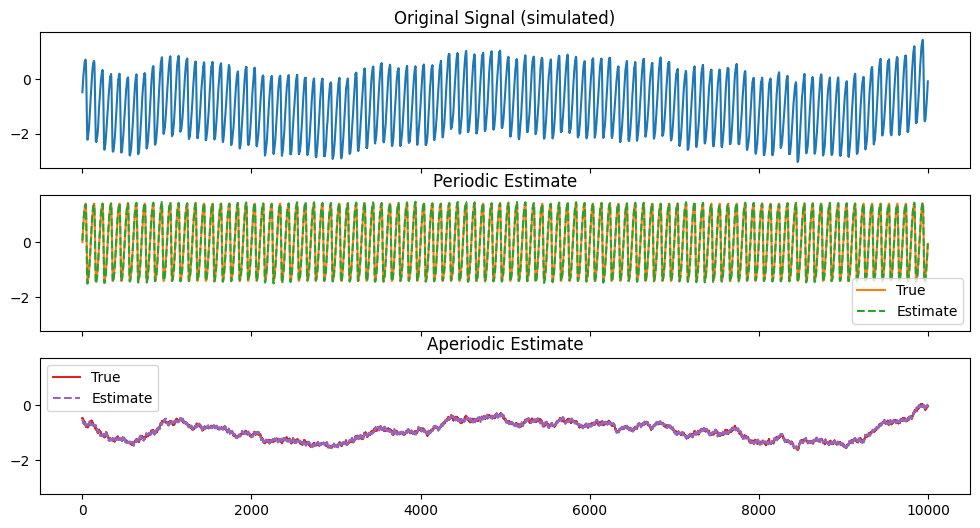

In [22]:
fig, axes = plt.subplots(nrows=3, figsize=(12, 6), sharey=True, sharex=True)

i = 10000
axes[0].plot(sig[:i])
axes[0].set_title('Original Signal (simulated)')

axes[1].plot((sig_pe)[:i], color='C1', label='True')
axes[1].plot((sig-sig_ap_pred)[:i], color='C2', ls='--', label='Estimate')
axes[1].set_title('Periodic Estimate')
axes[1].legend()

axes[2].plot((sig_ap)[:i], color='C3', label='True')
axes[2].plot((sig_ap_pred)[:i], color='C4', ls='--', label='Estimate')
axes[2].set_title('Aperiodic Estimate')
axes[2].legend();

## Simulated Bursty Sawtooth

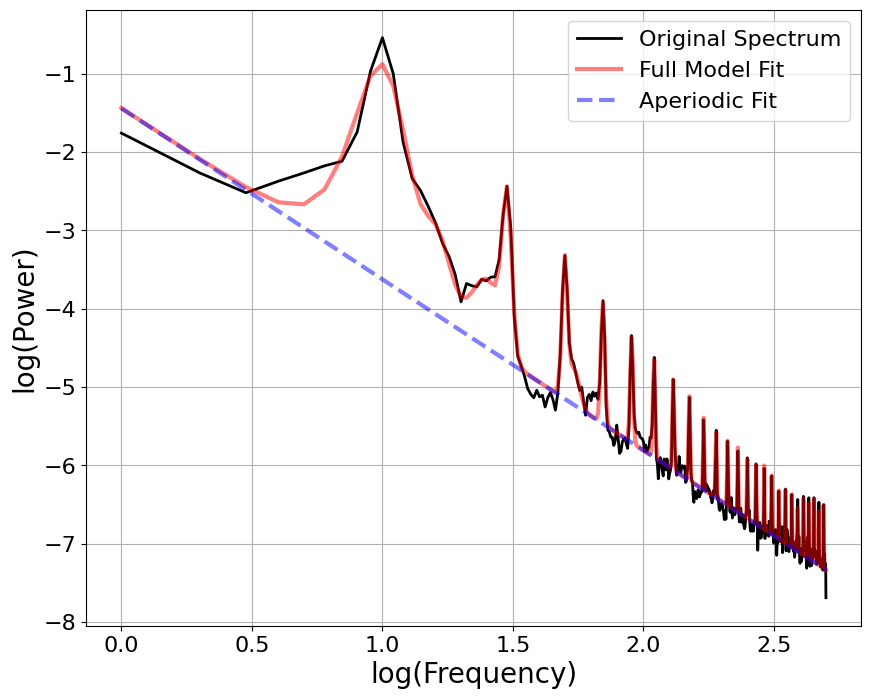

In [72]:
n_seconds = 25
fs = 1000

# Simulate
np.random.seed(0)
sig_ap = sim_powerlaw(n_seconds, fs)
sig_pe = sim_bursty_oscillation(n_seconds, fs, 10, cycle='sawtooth', width=.5, phase=0.25)
sig = sig_ap + sig_pe

# SpecParam
freqs, powers = compute_spectrum(sig, fs)
fm = FOOOF(max_n_peaks=30, verbose=False)

fm.fit(freqs, powers)
fm.plot(plt_log=True)

In [73]:
# Forward psd function
psdfunc = lambda sig : psdfunc_wrap(sig, fs)

ffreqs = fftfreq(len(sig), 1/fs)
fcoefs = fft(sig)

# Target PSD
powers_ap_log = fm._spectrum_peak_rm

# Fourier periodic mask
inds = fm._peak_fit > .5
fpad = 1

ffreqs_abs = np.abs(ffreqs)
fmask = np.zeros(len(ffreqs), dtype=bool)

for f in fm.freqs[inds]:
    fmask[(ffreqs_abs >= f-fpad) & (ffreqs_abs <= f+fpad)] = True

# Inital fourier coefficient weights and bounds
pinit = np.append(
    np.ones(fmask.sum()),
    np.zeros(fmask.sum())
)

bounds = [(1e-24, 1.01)] * fmask.sum()
bounds.extend([[-10, 10]] * fmask.sum())


# Wrap loss and minimize
lloss = lambda params : loss(sig, fmask, powers_ap_log, psdfunc, ffreqs, fcoefs, fs, *params)

res = minimize(lloss, pinit, method="L-BFGS-B", bounds=bounds,
               options={'iprint': 20, 'maxiter': 300000, 'maxfun':300000})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21276D+00    |proj g|=  3.42572D-01

At iterate   20    f=  9.54195D-03    |proj g|=  1.36371D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10300     27     30     27     0     0   2.896D-03   7.624D-03
  F =   7.6236560197158222E-003

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


In [74]:
# Get results
opt_weights = res.x

sig_ap_pred, fcoefs_pred, powers_pred_log = apply_fourier_weights(fcoefs, opt_weights)

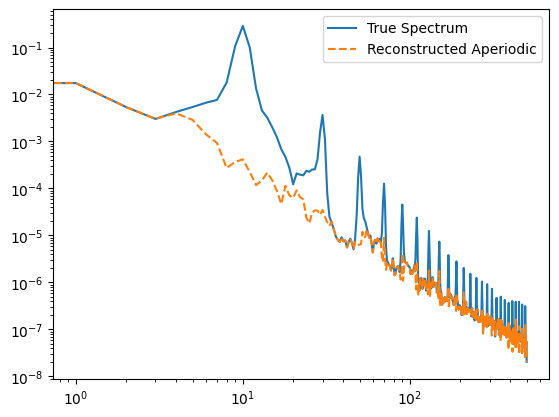

In [75]:
_freqs, _powers = compute_spectrum(sig, fs)

plt.loglog(*compute_spectrum(sig, fs), label='True Spectrum')
plt.loglog(*compute_spectrum(sig_ap_pred, fs), ls='--', label='Reconstructed Aperiodic')
plt.legend();

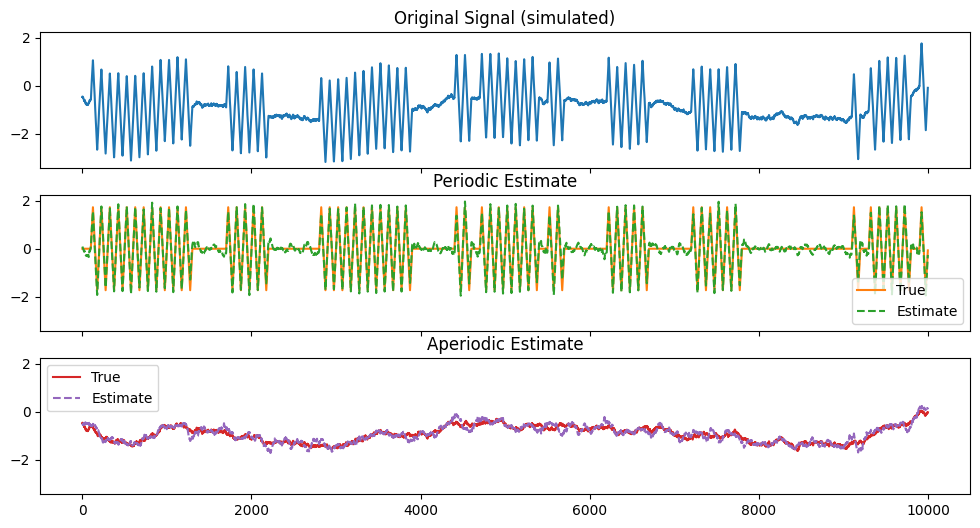

In [76]:
fig, axes = plt.subplots(nrows=3, figsize=(12, 6), sharey=True, sharex=True)

i = 10000
axes[0].plot(sig[:i])
axes[0].set_title('Original Signal (simulated)')

axes[1].plot((sig_pe)[:i], color='C1', label='True')
axes[1].plot((sig-sig_ap_pred)[:i], color='C2', ls='--', label='Estimate')
axes[1].set_title('Periodic Estimate')
axes[1].legend()

axes[2].plot((sig_ap)[:i], color='C3', label='True')
axes[2].plot((sig_ap_pred)[:i], color='C4', ls='--', label='Estimate')
axes[2].set_title('Aperiodic Estimate')
axes[2].legend();